In [1]:
# Import the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt

import os
import pathlib

### Download and explore the dataset

Begin by downloading the Stack Overflow dataset using `tf.keras.utils.get_file`, and exploring the directory structure:

In [2]:
stack_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

In [3]:
# Load the dataset
dataset = tf.keras.utils.get_file(origin = stack_url, 
                                  untar = True,
                                  cache_dir = "stack_overflow",
                                  cache_subdir ="." )

print(dataset) # gives the path of dataset

/tmp\.keras\.\stack_overflow_16k


In [4]:
# Convert to windows path
dataset_dir = pathlib.Path(dataset).parent
dataset_dir

WindowsPath('/tmp/.keras')

In [5]:
list(dataset_dir.iterdir())

[WindowsPath('/tmp/.keras/README.md'),
 WindowsPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 WindowsPath('/tmp/.keras/test'),
 WindowsPath('/tmp/.keras/train')]

In [6]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[WindowsPath('/tmp/.keras/train/csharp'),
 WindowsPath('/tmp/.keras/train/java'),
 WindowsPath('/tmp/.keras/train/javascript'),
 WindowsPath('/tmp/.keras/train/python')]

In [7]:
train_dir

WindowsPath('/tmp/.keras/train')

In [8]:
test_dir = dataset_dir/'test'
list(test_dir.iterdir())

[WindowsPath('/tmp/.keras/test/csharp'),
 WindowsPath('/tmp/.keras/test/java'),
 WindowsPath('/tmp/.keras/test/javascript'),
 WindowsPath('/tmp/.keras/test/python')]

The `train/csharp`, `train/java`, `train/python` and `train/javascript` directories contain many text files, each of which is a Stack Overflow question.

Print an example file and inspect the data:

In [9]:
sample_file = train_dir/'csharp/0.txt'
with open(sample_file) as f:
    print(f.read())


"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much 

### Load the dataset

Next, you will load the data off-disk and prepare it into a format suitable for training. To do so, you will use the `tf.keras.utils.text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. If you're new to `tf.data`, it's a powerful collection of tools for building input pipelines. (Learn more in the [tf.data: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.)

The `tf.keras.utils.text_dataset_from_directory` API expects a directory structure as follows:

```
train/
...csharp/
......1.txt
......2.txt
...java/
......1.txt
......2.txt
...javascript/
......1.txt
......2.txt
...python/
......1.txt
......2.txt
```

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [training](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The Stack Overflow dataset has already been divided into training and test sets, but it lacks a validation set.

Create a validation set using an 80:20 split of the training data by using `tf.keras.utils.text_dataset_from_directory` with `validation_split` set to `0.2` (i.e. 20%):

In [10]:
BATCH_SIZE = 32
train_set = tf.keras.utils.text_dataset_from_directory(train_dir, 
                                                       shuffle= True,
                                                       seed = 30,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       batch_size = BATCH_SIZE)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As the previous cell output suggests, there are 8,000 examples in the training folder, of which you will use 80% (or 6,400) for training. You will learn in a moment that you can train a model by passing a `tf.data.Dataset` directly to `Model.fit`.

First, iterate over the dataset and print out a few examples, to get a feel for the data.

Note: To increase the difficulty of the classification problem, the dataset author replaced occurrences of the words *Python*, *CSharp*, *JavaScript*, or *Java* in the programming question with the word *blank*.

In [11]:
class_name = train_set.class_names
class_name

['csharp', 'java', 'javascript', 'python']

In [12]:
for i, name in enumerate(train_set.class_names):
    print(f"The Label: {i} stands for the class name: {name} ")

The Label: 0 stands for the class name: csharp 
The Label: 1 stands for the class name: java 
The Label: 2 stands for the class name: javascript 
The Label: 3 stands for the class name: python 


In [13]:
for text_batch, label_batch in train_set.take(1):
  for i in range(5):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'can an arraylist of node contain non-node type? can an arraylist of node contain a non-node type? ..is there a very dirty method of doing this with type casting?\n'
Label: 1
Question:  b'"call baseclass method on extendedclass object when defined as baseclass imagine following code:..public class baseclass {.    private int a;..    public void noreturnnoparam() {.        system.out.println(""from base class"");.    }.}..public class extendedclass extends baseclass {.    private int b;..    @override.    public void noreturnnoparam() {.        system.out.println(""from extended class"");.    }.}..public class polymorph {.    public static void main(string... args) {.        baseclass bc = new baseclass();.        extendedclass ec = new extendedclass();.        baseclass bcec = new extendedclass();..        bc.noreturnnoparam();.        ec.noreturnnoparam();.        bcec.noreturnnoparam();.    }.}...output is as follows:..from base class.from extended class.from extended cla

Next, you will create a validation and a test set using `tf.keras.utils.text_dataset_from_directory`. You will use the remaining 1,600 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments of `tf.keras.utils.text_dataset_from_directory`, make sure to either specify a random seed or pass `shuffle=False`, so that the validation and training splits have no overlap.

In [14]:
val_set = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                     validation_split = 0.2,
                                                     subset = 'validation',
                                                     batch_size = BATCH_SIZE,
                                                     shuffle = True,
                                                     seed = 30)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [15]:
test_set = tf.keras.utils.text_dataset_from_directory(test_dir,
                                                      batch_size = BATCH_SIZE)

Found 8000 files belonging to 4 classes.


### Configure the datasets for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

- `Dataset.cache` keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [16]:
train_set = train_set.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Next, you will standardize, tokenize, and vectorize the data using the `tf.keras.layers.TextVectorization` layer.

- _Standardization_ refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
- _Tokenization_ refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).
- _Vectorization_ refers to converting tokens into numbers so they can be fed into a neural network.

All of these tasks can be accomplished with this layer. (You can learn more about each of these in the `tf.keras.layers.TextVectorization` API docs.)

Note that:

- The default standardization converts text to lowercase and removes punctuation (`standardize='lower_and_strip_punctuation'`).
- The default tokenizer splits on whitespace (`split='whitespace'`).
- The default vectorization mode is `'int'` (`output_mode='int'`). This outputs integer indices (one per token). This mode can be used to build models that take word order into account.

For the `'int'` mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length (`MAX_SEQUENCE_LENGTH`), which will cause the layer to pad or truncate sequences to exactly `output_sequence_length` values:

In [17]:
VOCAB_LENGTH = 10000
MAX_SEQUENCE_LENGTH = 250

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens= VOCAB_LENGTH,
                                                    output_sequence_length = MAX_SEQUENCE_LENGTH,
                                                    output_mode = 'int')

Next, call `TextVectorization.adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling `TextVectorization.adapt`, as using the test set would leak information.

In [18]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_set_text = train_set.map(lambda text, label: text)
vectorize_layer.adapt(train_set_text)

Print the result of using these layers to preprocess data:

In [19]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(train_set))
first_text, first_label = text_batch[0], label_batch[0]
print(f"The first question is {first_text}")
print(f"The label of first question is {first_label}")

The first question is b'"blank - reading through the same file from different starting lines i am trying to read a .non file (you can find an example here)..those files contains 4 keys: width, height, rows and columns (both are made of multiple values)...width and height are always before rows, columns or in my case goal, thus i have to go through the file while not knowing when i\'ll find what i need...here\'s what i\'m trying to do:..# this function will create the grid.def fcreate(grid_id):.    gridfile = open(grid_id[\'grid\'], ""r"").    # here, we\'re going through the entire file, getting the values we need..    # still working on a pretty way to make the dictionary !.    for line in gridfile:.        if ""width"" in line:.            grid_id[\'width\'] = re.sub(\'[a-z]\', \'\', line).strip().        if ""height"" in line:.            grid_id[\'height\'] = re.sub(\'[a-z]\', \'\', line).strip().        if ""rows"" in line:.            # get all the rows values until something els

In [20]:
print("'int' vectorized question:",
      vectorize_layer(first_text).numpy())

'int' vectorized question: [  16  437  194    2  115   40   31  180  743  299    3   34   83    4
  167    5 2233   40   59   36  145   32  138    1  171  291  139  577
  368  361  526    8  682  278   58  454    9  266    1    8  361   58
  326  272  526  682   45    7   23  135 1183 1597    3   17    4  314
  194    2   40  110   21 3657   46 1047  145   53    3    1   53   51
   83    4   39   13   38   72  127    2    1    1    1    1  317  100
  540  395  194    2 1009   40  149    2  130  168   79  279  157   37
    5  811   86    4  112    2  393   12   76    7    1   11  368    7
   76    1    1 3239   11  361    7   76    1    1 3239   11  526    7
   76   41   77    2  526  130  480  147   55   45 3274   11  682    7
   76   41   77    2  682  130  480  147   55   45 3274  211    9    2
   12    1   26 6596    1  291   77    2  130    3   17    4    1  144
  440    5   15   12    7    2   11  526    5  110    8    1   27  166
  459    4 2496  581  437  194    2 1009   40  302

As shown above, `TextVectorization`'s `'binary'` mode returns an array denoting which tokens exist at least once in the input, while the `'int'` mode replaces each token by an integer, thus preserving their order.

In [21]:
print("1289 ---> ", vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1289 --->  calculation
313 --->  running
Vocabulary size: 10000


In [22]:
from tensorflow.keras import layers, regularizers, callbacks

In [23]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 3, padding="valid", activation="relu", strides=1),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels, kernel_regularizer=regularizers.l2(0.01))
    ])
  

  model = tf.keras.Sequential(my_layers)
  return model
     

Next, We will use the `'int'` vectorized layer to build a 1D ConvNet:

In [24]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_LENGTH + 1, 
                         num_labels=4, 
                         vectorizer=vectorize_layer)


In [25]:
int_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# int_history = int_model.fit(train_set, validation_data=val_set, epochs=10)

Epoch 1/10


c:\Users\ashar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3359 - loss: 1.3987 - val_accuracy: 0.6281 - val_loss: 0.9411
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6525 - loss: 0.8886 - val_accuracy: 0.6988 - val_loss: 0.7596
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7306 - loss: 0.7089 - val_accuracy: 0.7556 - val_loss: 0.6739
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7998 - loss: 0.5981 - val_accuracy: 0.7700 - val_loss: 0.6276
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8517 - loss: 0.5007 - val_accuracy: 0.7844 - val_loss: 0.6055
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8873 - loss: 0.4238 - val_accuracy: 0.7975 - val_loss: 0.5935
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9107 - loss: 0.3585 - val_accuracy: 0.7981 - val_loss: 0.5943
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9317 - loss: 0.2958 - val_accuracy: 0.803

In [ ]:
int_history = int_model.fit(train_set, validation_data=val_set, epochs=10)

In [26]:
int_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 250, 64)        │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 248, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,958,030 (7.47 MB)

 Trainable params: 652,676 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,305,354 (4.98 MB)

Text(0, 0.5, 'Accuracy')

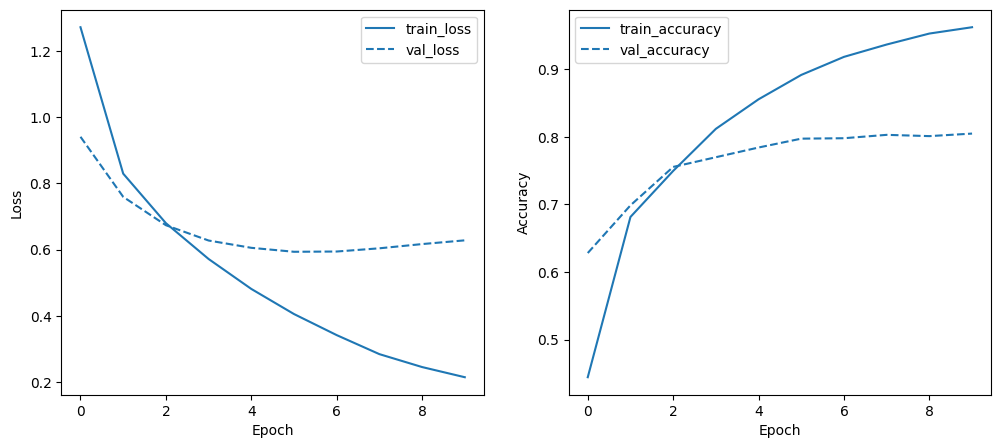

In [27]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
loss = plt.plot(int_history.epoch, int_history.history['loss'], label='train_loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
loss = plt.plot(int_history.epoch, int_history.history['accuracy'], label='train_accuracy')
plt.plot(int_history.epoch, int_history.history['val_accuracy'], '--', color=loss[0].get_color(), label='val_accuracy')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = int_model.evaluate(test_set)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7975 - loss: 0.6167
Test Loss: 0.6160263419151306
Test Accuracy: 0.796500027179718


In [30]:
input_shape = int_model.input_shape
input_dtype = int_model.input_dtype
print(f"Model input shape: {input_shape}")
print(f"Model input data type: {input_dtype}")


Model input shape: (None,)
Model input data type: string


### Check the performance of the model on the actual questions

In [31]:
import numpy as np
examples = tf.constant([
  "how to reverse the list usinh list comprehension",
  '''class Main {
   public void printArray(int[] array){
       for(int i : array)
           System.out.println(i);
   }
   public static void main(String args[]) {
       int[] array = new int[10];
       printArray(array);
   }'''
])

for i in (int_model.predict(examples)):
    print(class_name[np.argmax(i)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
python
java
